# Multivoxel Pattern Analysis 

In [32]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import pickle

from nltools.data import Brain_Data
from nltools.mask import expand_mask, collapse_mask
from nltools.analysis import Roc
from itertools import combinations
from joblib import Parallel, delayed
import scipy.stats as stats

from matplotlib import pyplot as plt
import seaborn as sns

***

# Collect Averaged Betas

In [2]:
betas_dir = 'betas/averaged_betas/'

carep_betas = glob.glob(betas_dir+'*Phys*')
carep_betas.sort()

carem_betas = glob.glob(betas_dir+'*Emo*')
carem_betas.sort()

fair_betas = glob.glob(betas_dir+'*Fair*')
fair_betas.sort()

lib_betas = glob.glob(betas_dir+'*Lib*')
lib_betas.sort()

loy_betas = glob.glob(betas_dir+'*Loy*')
loy_betas.sort()

auth_betas = glob.glob(betas_dir+'*Auth*')
auth_betas.sort()

sanc_betas = glob.glob(betas_dir+'*Sanc*')
sanc_betas.sort()

socn_betas = glob.glob(betas_dir+'*Soc*')
socn_betas.sort()

In [3]:
# avg_beta_imgs = {'Physical Care': Brain_Data(carep_betas),
#              'Emotional Care': Brain_Data(carem_betas),
#              'Fairness': Brain_Data(fair_betas),
#              'Liberty': Brain_Data(lib_betas),
#              'Loyalty': Brain_Data(loy_betas),
#              'Authority': Brain_Data(auth_betas),
#              'Sanctity': Brain_Data(sanc_betas),
#              'Social Norms': Brain_Data(socn_betas)
#             }

# with open('output/avg_betas.pkl', 'wb') as handle:
#     pickle.dump(beta_imgs, handle)

with open('output/avg_betas.pkl' , 'rb') as f:
    avg_beta_imgs = pickle.load(f)

# MVPA Classification

## Neurosynth Masks

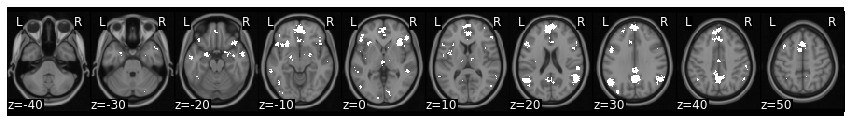

In [5]:
neurosynth_moral = Brain_Data('masks/moral_uniformity-test_z_FDR_0.01.nii.gz').threshold(1, binarize=True)
neurosynth_moral.plot()

## Moral ROIs Mask

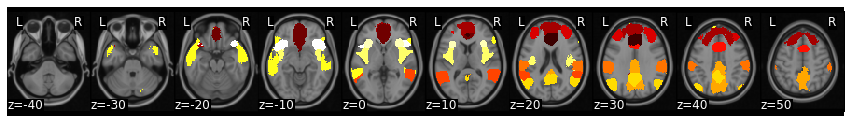

In [12]:
# Parcelation
brain_mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
brain_mask_x = expand_mask(brain_mask)

# Moral Rois
moral_rois = {
            0:'amPFC',
            32:'vmPFC',
            2:'dmPFC',
            44:'dlPFC',
            22:'dACC',
            5:'TPJ/Ang. Gyrus',
            15:'TPJ/Par. Operculum',
            6:'PCC/Precuneus',
            19:'PCC/Superior LOC',
            49:'STS',
            16:'mInsula',
            18:'daInsula',
            37:'vaInsula'
}

moral_rois_mask = collapse_mask(brain_mask_x[list(moral_rois.keys())])
moral_rois_mask_x = expand_mask(moral_rois_mask)
moral_rois_mask.plot()

In [13]:
sub_list = ["sub-" + "{0:0>2}".format(x) for x in range(1,65)]
subject_id = np.concatenate([sub_list,sub_list])

## Whole-Brain

In [14]:
loso_wb_svm_stats = {}
loso_wb_roc_stats = {}

for conditions in list(combinations(avg_beta_imgs.keys(), 2)):
    print("Starting SVM for: ", conditions)
    ## ---- Whole-Brain SVM ---- ###
    data = avg_beta_imgs[conditions[0]].append(avg_beta_imgs[conditions[1]])
    Y = pd.DataFrame(np.hstack([np.ones(64), np.zeros(64)]))
    data.Y = Y
    # Run LOSO SVM
    svm_stat = data.predict(algorithm='svm', cv_dict={'type': 'loso','subject_id':subject_id}, 
                            **{'kernel':"linear"}, plot=False, verbose=0)
    loso_wb_svm_stats[conditions] = svm_stat
    
    # Forced-choice test ROC
    roc_fc = Roc(input_values=svm_stat['dist_from_hyperplane_xval'], 
                 binary_outcome=svm_stat['Y'].astype(bool), forced_choice=subject_id)
    
    roc_fc.calculate()
    loso_wb_roc_stats[conditions] = roc_fc
    print("Completed Whole-Brain SVM")

Starting SVM for:  ('Physical Care', 'Emotional Care')
overall accuracy: 1.00
overall CV accuracy: 0.86
Completed Whole-Brain SVM
Starting SVM for:  ('Physical Care', 'Fairness')
overall accuracy: 1.00
overall CV accuracy: 0.88
Completed Whole-Brain SVM
Starting SVM for:  ('Physical Care', 'Liberty')
overall accuracy: 1.00
overall CV accuracy: 0.90
Completed Whole-Brain SVM
Starting SVM for:  ('Physical Care', 'Loyalty')
overall accuracy: 1.00
overall CV accuracy: 0.95
Completed Whole-Brain SVM
Starting SVM for:  ('Physical Care', 'Authority')
overall accuracy: 1.00
overall CV accuracy: 0.89
Completed Whole-Brain SVM
Starting SVM for:  ('Physical Care', 'Sanctity')
overall accuracy: 1.00
overall CV accuracy: 0.79
Completed Whole-Brain SVM
Starting SVM for:  ('Physical Care', 'Social Norms')
overall accuracy: 1.00
overall CV accuracy: 0.90
Completed Whole-Brain SVM
Starting SVM for:  ('Emotional Care', 'Fairness')
overall accuracy: 1.00
overall CV accuracy: 0.71
Completed Whole-Brain SV

In [15]:
with open('output/loso_wb_svm.pkl', 'wb') as handle:
    pickle.dump(loso_wb_svm_stats, handle)
with open('output/loso_wb_roc.pkl', 'wb') as handle:
    pickle.dump(loso_wb_roc_stats, handle)

## Neurosynth Masks

In [41]:
loso_moral_svm_stats = {}
loso_moral_roc_stats = {}

for conditions in list(combinations(avg_beta_imgs.keys(), 2)):
    print("Starting SVM for: ", conditions)    
    
    ## ---- Moral SVM ---- ###
    data = avg_beta_imgs[conditions[0]].apply_mask(neurosynth_moral).append(avg_beta_imgs[conditions[1]].apply_mask(neurosynth_moral))
    Y = pd.DataFrame(np.hstack([np.ones(64), np.zeros(64)]))
    data.Y = Y
    # Run LOSO SVM
    svm_stat = data.predict(algorithm='svm', cv_dict={'type': 'loso','subject_id':subject_id}, 
                            **{'kernel':"linear"}, plot=False, verbose=0)
    loso_moral_svm_stats[conditions] = svm_stat
    
    # Forced-choice test ROC
    roc_fc = Roc(input_values=svm_stat['dist_from_hyperplane_xval'], 
                 binary_outcome=svm_stat['Y'].astype(bool), forced_choice=subject_id)
    
    roc_fc.calculate()
    loso_moral_roc_stats[conditions] = roc_fc
    print("Completed Moral SVM")

Starting SVM for:  ('Physical Care', 'Emotional Care')
overall accuracy: 1.00
overall CV accuracy: 0.79
Completed Moral SVM
Starting SVM for:  ('Physical Care', 'Fairness')
overall accuracy: 1.00
overall CV accuracy: 0.80
Completed Moral SVM
Starting SVM for:  ('Physical Care', 'Liberty')
overall accuracy: 1.00
overall CV accuracy: 0.79
Completed Moral SVM
Starting SVM for:  ('Physical Care', 'Loyalty')
overall accuracy: 1.00
overall CV accuracy: 0.88
Completed Moral SVM
Starting SVM for:  ('Physical Care', 'Authority')
overall accuracy: 1.00
overall CV accuracy: 0.81
Completed Moral SVM
Starting SVM for:  ('Physical Care', 'Sanctity')
overall accuracy: 1.00
overall CV accuracy: 0.72
Completed Moral SVM
Starting SVM for:  ('Physical Care', 'Social Norms')
overall accuracy: 1.00
overall CV accuracy: 0.80
Completed Moral SVM
Starting SVM for:  ('Emotional Care', 'Fairness')
overall accuracy: 1.00
overall CV accuracy: 0.70
Completed Moral SVM
Starting SVM for:  ('Emotional Care', 'Liberty

In [42]:
# with open('output/loso_moral_svm.pkl', 'wb') as handle:
#     pickle.dump(loso_moral_svm_stats, handle)
# with open('output/loso_moral_roc.pkl', 'wb') as handle:
#     pickle.dump(loso_moral_roc_stats, handle)

## ROIs

In [14]:
# loso_roi_svm_stats = {k:{} for k in moral_rois.values()}
# loso_roi_roc_stats = {k:{} for k in moral_rois.values()}

# for conditions in list(combinations(avg_beta_imgs.keys(), 2)):
#     print("Starting SVM for: ", conditions)
#     ## ---- ROI SVM ---- ###
#     data = avg_beta_imgs[conditions[0]].append(avg_beta_imgs[conditions[1]])
#     Y = pd.DataFrame(np.hstack([np.ones(64), np.zeros(64)]))
#     data.Y = Y
#     svm_stat_rois = data.predict_multi(algorithm='svm', method='rois',rois=moral_rois_mask_x, n_jobs=-1,
#                                    cv_dict={'type': 'loso','subject_id':subject_id}, **{'kernel':"linear"})
        
#     for ix, roi in enumerate(moral_rois.values()):
#         loso_roi_svm_stats[roi][conditions] = svm_stat_rois[ix]
#         # Forced-choice test ROC
#         roc_fc = Roc(input_values=svm_stat_rois[ix]['dist_from_hyperplane_xval'], 
#                  binary_outcome=svm_stat_rois[ix]['Y'].astype(bool), forced_choice=subject_id)
    
#         roc_fc.calculate()
#         loso_roi_roc_stats[roi][conditions] = roc_fc
#     print("Completed ROI SVM")

Starting SVM for:  ('Physical Care', 'Emotional Care')
Completed ROI SVM
Starting SVM for:  ('Physical Care', 'Fairness')
Completed ROI SVM
Starting SVM for:  ('Physical Care', 'Liberty')
Completed ROI SVM
Starting SVM for:  ('Physical Care', 'Loyalty')
Completed ROI SVM
Starting SVM for:  ('Physical Care', 'Authority')
Completed ROI SVM
Starting SVM for:  ('Physical Care', 'Sanctity')
Completed ROI SVM
Starting SVM for:  ('Physical Care', 'Social Norms')
Completed ROI SVM
Starting SVM for:  ('Emotional Care', 'Fairness')
Completed ROI SVM
Starting SVM for:  ('Emotional Care', 'Liberty')
Completed ROI SVM
Starting SVM for:  ('Emotional Care', 'Loyalty')
Completed ROI SVM
Starting SVM for:  ('Emotional Care', 'Authority')
Completed ROI SVM
Starting SVM for:  ('Emotional Care', 'Sanctity')
Completed ROI SVM
Starting SVM for:  ('Emotional Care', 'Social Norms')
Completed ROI SVM
Starting SVM for:  ('Fairness', 'Liberty')
Completed ROI SVM
Starting SVM for:  ('Fairness', 'Loyalty')
Complet

In [15]:
# with open('output/loso_roi_svm.pkl', 'wb') as handle:
#     pickle.dump(loso_roi_svm_stats, handle)
# with open('output/loso_roi_roc.pkl', 'wb') as handle:
#     pickle.dump(loso_roi_roc_stats, handle)

***

# MVPA Results

In [19]:
with open('output/loso_wb_svm.pkl', 'rb') as handle:
    loso_wb_svm_stats=pickle.load(handle)
with open('output/loso_wb_roc.pkl', 'rb') as handle:
    loso_wb_roc_stats=pickle.load(handle)
    
with open('output/loso_moral_svm.pkl', 'rb') as handle:
    loso_moral_svm_stats=pickle.load(handle)
with open('output/loso_moral_roc.pkl', 'rb') as handle:
    loso_moral_roc_stats=pickle.load(handle)
    
with open('output/loso_roi_svm.pkl', 'rb') as handle:
    loso_roi_svm_stats=pickle.load(handle)
with open('output/loso_roi_roc.pkl', 'rb') as handle:
    loso_roi_roc_stats=pickle.load(handle)

In [20]:
# Whole Brain Forced-Choice Accuracies
loso_wb_fc_acc = pd.DataFrame(index=avg_beta_imgs.keys(), columns=avg_beta_imgs.keys())
print('P-Values Whole Brain Loso')
for contrast, roc in loso_wb_roc_stats.items():
    loso_wb_fc_acc.at[contrast[0], contrast[1]] = roc.accuracy
    loso_wb_fc_acc.at[contrast[1], contrast[0]] = roc.accuracy
    print(contrast, round(roc.accuracy_p,4))

# Neurosynth Forced-Choice Accuracies
loso_moral_fc_acc = pd.DataFrame(index=avg_beta_imgs.keys(), columns=avg_beta_imgs.keys())
for contrast, roc in loso_moral_roc_stats.items():
    loso_moral_fc_acc.at[contrast[0], contrast[1]] = roc.accuracy
    loso_moral_fc_acc.at[contrast[1], contrast[0]] = roc.accuracy
    
# ROIs Forced-Choice Accuracies
loso_roi_fc_acc = {}
for roi, roc_dict in loso_roi_roc_stats.items():
    roi_acc = pd.DataFrame(index=avg_beta_imgs.keys(), columns=avg_beta_imgs.keys())
    for contrast, roc in roc_dict.items():
        roi_acc.at[contrast[0], contrast[1]] = roc.accuracy
        roi_acc.at[contrast[1], contrast[0]] = roc.accuracy
    loso_roi_fc_acc[roi] = roi_acc

P-Values Whole Brain Loso
('Physical Care', 'Emotional Care') 0.0
('Physical Care', 'Fairness') 0.0
('Physical Care', 'Liberty') 0.0
('Physical Care', 'Loyalty') 0.0
('Physical Care', 'Authority') 0.0
('Physical Care', 'Sanctity') 0.0
('Physical Care', 'Social Norms') 0.0
('Emotional Care', 'Fairness') 0.0
('Emotional Care', 'Liberty') 0.0
('Emotional Care', 'Loyalty') 0.0
('Emotional Care', 'Authority') 0.0
('Emotional Care', 'Sanctity') 0.0
('Emotional Care', 'Social Norms') 0.0
('Fairness', 'Liberty') 0.0
('Fairness', 'Loyalty') 0.0
('Fairness', 'Authority') 0.0
('Fairness', 'Sanctity') 0.0
('Fairness', 'Social Norms') 0.0
('Liberty', 'Loyalty') 0.0
('Liberty', 'Authority') 0.0
('Liberty', 'Sanctity') 0.0
('Liberty', 'Social Norms') 0.0
('Loyalty', 'Authority') 0.0
('Loyalty', 'Sanctity') 0.0
('Loyalty', 'Social Norms') 0.0
('Authority', 'Sanctity') 0.0
('Authority', 'Social Norms') 0.0
('Sanctity', 'Social Norms') 0.0


## Visualization LOSO-MVPA Results

In [22]:
avg_beta_imgs.keys()

dict_keys(['Physical Care', 'Emotional Care', 'Fairness', 'Liberty', 'Loyalty', 'Authority', 'Sanctity', 'Social Norms'])

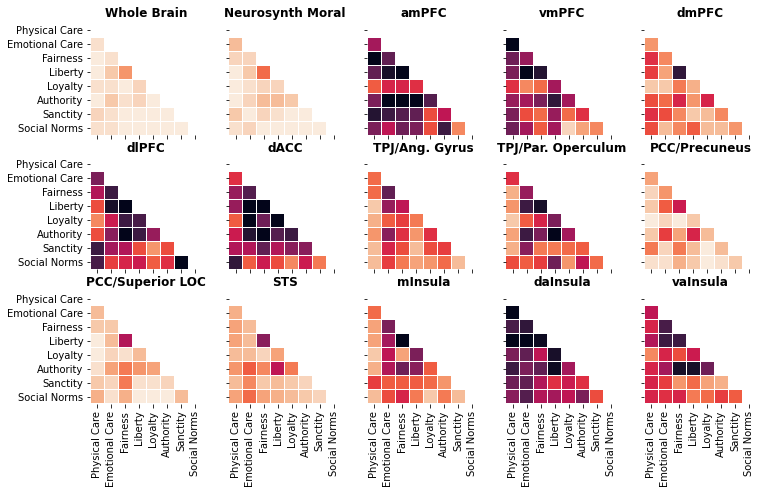

In [27]:
fig, ax = plt.subplots(3,5, figsize=(12,7), sharex=True, sharey=True)
mask = np.zeros_like(loso_wb_fc_acc)
mask[np.triu_indices_from(mask)] = True

for cidx, (roi, df) in enumerate(loso_roi_fc_acc.items()):
    cidx += 2
    ax_plot = ax[int(cidx / 5), int(cidx % 5)]
    sns.heatmap(ax=ax_plot, mask=mask, data=df.fillna(0), annot=False, square=True, vmin=0.5, vmax=1, cbar=False, linewidths=.1)
    ax_plot.set_yticklabels(avg_beta_imgs.keys())
    ax_plot.set_xticklabels(avg_beta_imgs.keys())
    ax_plot.set_title(roi, weight='bold')
    
ax_wb_plot = ax[0,0]
sns.heatmap(ax=ax_wb_plot, mask=mask,  data=loso_wb_fc_acc.fillna(1), annot=False, square=True, vmin=0.5, vmax=1, cbar=False, linewidths=.1)
ax_wb_plot.set_yticklabels(avg_beta_imgs.keys())
ax_wb_plot.set_xticklabels(avg_beta_imgs.keys())
ax_wb_plot.set_title('Whole Brain', weight='bold')

ax_ns_plot = ax[0,1]
sns.heatmap(ax=ax_ns_plot, mask=mask,  data=loso_moral_fc_acc.fillna(1), annot=False, square=True, vmin=0.5, vmax=1, cbar=False, linewidths=.1)
ax_ns_plot.set_yticklabels(avg_beta_imgs.keys())
ax_ns_plot.set_xticklabels(avg_beta_imgs.keys())
ax_ns_plot.set_title('Neurosynth Moral', weight='bold')
plt.savefig("plots/loso_mvpa.png", dpi=300, bbox_inches="tight")

In [28]:
loso_wb_fc_acc

,Physical Care,Emotional Care,Fairness,Liberty,Loyalty,Authority,Sanctity,Social Norms
Physical Care,NaN,0.984375,1,1,0.984375,1,0.96875,0.984375
Emotional Care,0.984375,NaN,0.984375,0.953125,0.984375,0.953125,0.984375,0.984375
Fairness,1,0.984375,NaN,0.890625,1,0.984375,1,1
Liberty,1,0.953125,0.890625,NaN,0.96875,0.96875,1,1
Loyalty,0.984375,0.984375,1,0.96875,NaN,1,1,1
Authority,1,0.953125,0.984375,0.96875,1,NaN,1,1
Sanctity,0.96875,0.984375,1,1,1,1,NaN,1
Social Norms,0.984375,0.984375,1,1,1,1,1,NaN


In [38]:
loso_wb_fc_acc_flat = [x for x in loso_wb_fc_acc.to_numpy()[np.triu_indices(8)] if not pd.isnull(x)]
loso_moral_fc_acc_flat = [x for x in loso_moral_fc_acc.to_numpy()[np.triu_indices(8)] if not pd.isnull(x)]

loso_comp_acc = pd.DataFrame()
loso_comp_acc['Whole Brain'] = loso_wb_fc_acc_flat
loso_comp_acc['Neurosynth Moral'] = loso_moral_fc_acc_flat

loso_wb_fc_acc_flat = [x for x in loso_wb_fc_acc.to_numpy()[np.triu_indices(8)] if not pd.isnull(x)]
loso_moral_fc_acc_flat = [x for x in loso_moral_fc_acc.to_numpy()[np.triu_indices(8)] if not pd.isnull(x)]

loso_comp_acc = pd.DataFrame()
loso_comp_acc['Whole Brain'] = loso_wb_fc_acc_flat
loso_comp_acc['Neurosynth Moral'] = loso_moral_fc_acc_flat


for k,v in loso_roi_fc_acc.items():
    acc_s = [x for x in loso_roi_fc_acc[k].to_numpy()[np.triu_indices(8)] if not pd.isnull(x)]
    loso_comp_acc[k] = acc_s
    
loso_comp_acc = loso_comp_acc.melt(var_name='Feature', value_name='Accuracy')
ordered = loso_comp_acc.groupby('Feature').mean().sort_values('Accuracy',ascending=False).index

In [39]:
print(np.array(loso_wb_fc_acc_flat).mean() - np.array(loso_moral_fc_acc_flat).mean())
stats.ttest_ind(loso_wb_fc_acc_flat, loso_moral_fc_acc_flat)

0.01171875


Ttest_indResult(statistic=1.517448315704194, pvalue=0.13498657061551417)

## Statistical Comparison of Accuracies

In [40]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(loso_comp_acc['Accuracy'], loso_comp_acc['Feature'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Neurosynth Moral,PCC/Precuneus,-0.0474,0.8985,-0.1375,0.0427,False
Neurosynth Moral,PCC/Superior LOC,-0.0296,0.9,-0.1197,0.0605,False
Neurosynth Moral,STS,-0.0703,0.3318,-0.1604,0.0198,False
Neurosynth Moral,TPJ/Ang. Gyrus,-0.1395,0.001,-0.2296,-0.0494,True
Neurosynth Moral,TPJ/Par. Operculum,-0.2087,0.001,-0.2988,-0.1186,True
Neurosynth Moral,Whole Brain,0.0117,0.9,-0.0784,0.1018,False
Neurosynth Moral,amPFC,-0.3237,0.001,-0.4137,-0.2336,True
Neurosynth Moral,dACC,-0.317,0.001,-0.4071,-0.2269,True
Neurosynth Moral,daInsula,-0.3348,0.001,-0.4249,-0.2447,True
Neurosynth Moral,dlPFC,-0.2824,0.001,-0.3725,-0.1923,True


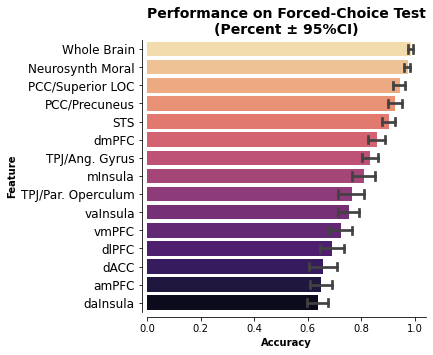

In [41]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(y='Feature', x='Accuracy', data=loso_comp_acc,capsize=.4, palette='magma_r', linewidth=.1, ci=95, order=ordered)
sns.despine(offset=5)
ax.set_yticklabels(labels = ordered,fontsize=12)
ax.set_title('Performance on Forced-Choice Test\n(Percent ± 95%CI)', weight='bold', fontsize=14)
ax.set_ylabel('Feature', weight='bold')
ax.set_xlabel('Accuracy', weight='bold')
plt.savefig('plots/loso_mvpa_accs.png', dpi=300, bbox_inches="tight")
plt.show()